In [2]:
from skfuzzy import control as ctrl
import skfuzzy as fuzz
import numpy as np

In [3]:
rule_txt = '''
RULES:

if NUM_PIECES is 'HIGH' then 'opening'
if NUM_PIECES is 'MEDIUM' then 'middlegame'
if NUM_PIECES is 'LOW' then 'endgame'


if NUM_MOVES is 'LOW' then 'opening'
if NUM_MOVES is 'MEDIUM' then 'middlegame'
if NUM_MOVES is 'HIGH' then 'endgame'

if BLACK_KING_FILE is 'advanced' AND WHITE_KING_FILE is 'advanced' then 'endgame'
if BLACK_KING_FILE is 'advanced' XOR WHITE_KING_FILE is 'advanced' then 'middlegame'
if BLACK_KING_FILE is not 'advanced' AND WHITE_KING_FILE is note 'advanced' then 'opening'
'''

In [4]:
# Create fuzzy variables
num_pieces = ctrl.Antecedent(np.arange(2, 33, 1), 'num_pieces')
num_moves = ctrl.Antecedent(np.arange(0, 150, 1), 'num_moves')
white_king_advanced_squares = ctrl.Antecedent(np.arange(1,9,1), 'white_king_advanced_squares')
black_king_advanced_squares = ctrl.Antecedent(np.arange(1,9,1), 'black_king_advanced_squares')
game_phase = ctrl.Consequent(np.linspace(0, 1, 50), 'game_phase')

/Users/davidferris/envs/env3.6/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


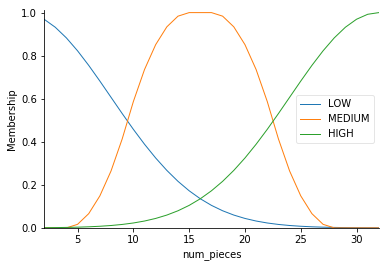

In [5]:
# Populate the fuzzy variables with membership functions
num_pieces['LOW'] = fuzz.gaussmf(num_pieces.universe, 0, 8)
num_pieces['MEDIUM'] = fuzz.pimf(num_pieces.universe, 4, 15, 17, 28)
num_pieces['HIGH'] = fuzz.gaussmf(num_pieces.universe, 32, 8)
num_pieces.view()

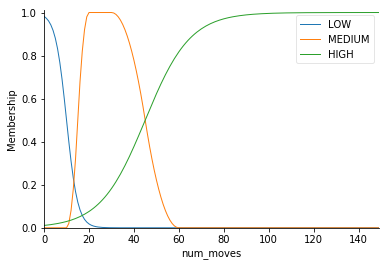

In [6]:
num_moves['LOW'] = fuzz.sigmf(num_moves.universe, 10, -.4)
num_moves['MEDIUM'] = fuzz.pimf(num_moves.universe, 10, 20, 30, 60)
num_moves['HIGH'] = fuzz.sigmf(num_moves.universe, 45, .1)
num_moves.view()

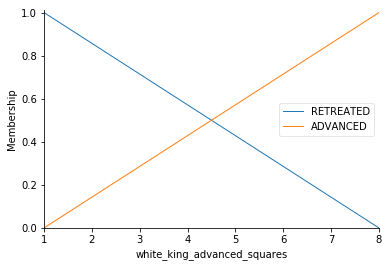

In [7]:
a = fuzz.trimf(black_king_advanced_squares.universe, [1,1,8])
b = fuzz.trimf(black_king_advanced_squares.universe, [1,8,8])
white_king_advanced_squares['RETREATED'] = a
white_king_advanced_squares['ADVANCED'] = b
black_king_advanced_squares['RETREATED'] = a
black_king_advanced_squares['ADVANCED'] = b
white_king_advanced_squares.view()

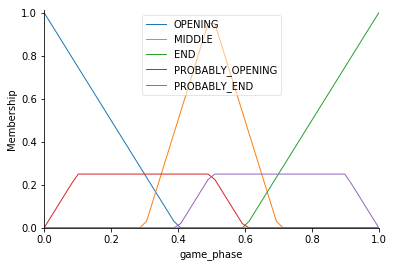

In [16]:
n = ['OPENING', 'MIDDLE', 'END']
# game_phase.automf(names=n)

game_phase['OPENING'] = fuzz.trimf(game_phase.universe, [0,0,.4])
game_phase['MIDDLE'] = fuzz.trimf(game_phase.universe, [.3,.5,.7])
game_phase['END'] = fuzz.trimf(game_phase.universe, [.6,1,1])

# Add extra game phases for king file rules.
game_phase['PROBABLY_OPENING'] = fuzz.trapmf(game_phase.universe, [0,.1,.5,.6])/4
game_phase['PROBABLY_END'] = fuzz.trapmf(game_phase.universe, [.4,.5,.9,1])/4

game_phase.view()

In [17]:
print(rule_txt)


RULES:

if NUM_PIECES is 'HIGH' then 'opening'
if NUM_PIECES is 'MEDIUM' then 'middlegame'
if NUM_PIECES is 'LOW' then 'endgame'


if NUM_MOVES is 'LOW' then 'opening'
if NUM_MOVES is 'MEDIUM' then 'middlegame'
if NUM_MOVES is 'HIGH' then 'endgame'

if BLACK_KING_FILE is 'advanced' AND WHITE_KING_FILE is 'advanced' then 'endgame'
if BLACK_KING_FILE is 'advanced' XOR WHITE_KING_FILE is 'advanced' then 'middlegame'
if BLACK_KING_FILE is not 'advanced' AND WHITE_KING_FILE is note 'advanced' then 'opening'



In [18]:
rules = [
    ctrl.Rule(antecedent=num_pieces['HIGH'], consequent=game_phase['OPENING']),
    ctrl.Rule(antecedent=num_pieces['MEDIUM'], consequent=game_phase['MIDDLE']),
    ctrl.Rule(antecedent=num_pieces['LOW'], consequent=game_phase['END']),

    ctrl.Rule(antecedent=num_moves['LOW'], consequent=game_phase['OPENING']),
    ctrl.Rule(antecedent=num_moves['MEDIUM'], consequent=game_phase['MIDDLE']),
    ctrl.Rule(antecedent=num_moves['HIGH'], consequent=game_phase['END']),
    
    ctrl.Rule(antecedent=(
        white_king_advanced_squares['RETREATED'] & black_king_advanced_squares['RETREATED']),
        consequent=game_phase['PROBABLY_OPENING']),
    ctrl.Rule(antecedent=(
        white_king_advanced_squares['ADVANCED'] & black_king_advanced_squares['ADVANCED']),
        consequent=game_phase['PROBABLY_END'])
]

In [19]:
system = ctrl.ControlSystem(rules=rules)
sim = ctrl.ControlSystemSimulation(system, flush_after_run=21*21+1)

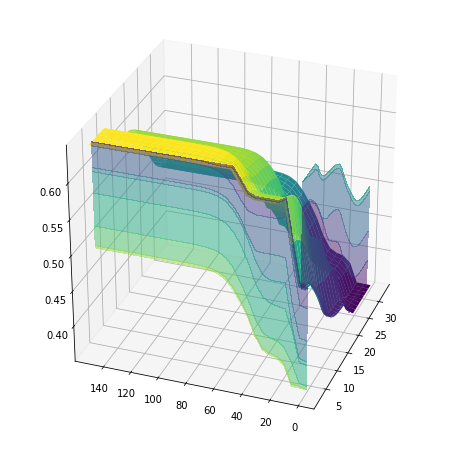

In [20]:
resolution = 30

x,y = np.meshgrid(np.linspace(2, 33, resolution), np.linspace(0, 150, resolution))

z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(resolution):
    for j in range(resolution):
        sim.input['num_pieces'] = x[i, j]
        sim.input['num_moves'] = y[i, j]
        sim.input['white_king_advanced_squares'] = 5
        sim.input['black_king_advanced_squares'] = 5
        sim.compute()
        z[i, j] = sim.output['game_phase']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)